# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [6]:
!wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip
!unzip pnp_dataset.zip >/dev/null 2>&1

--2021-09-26 06:06:52--  https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip
Resolving danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)... 52.218.242.89
Connecting to danylo-ucla.s3.us-west-2.amazonaws.com (danylo-ucla.s3.us-west-2.amazonaws.com)|52.218.242.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027495996 (980M) [application/zip]
Saving to: ‘pnp_dataset.zip’

pnp_dataset.zip     100%[===================>] 979.90M  26.1MB/s    in 45s     

2021-09-26 06:07:37 (21.7 MB/s) - ‘pnp_dataset.zip’ saved [1027495996/1027495996]



In [3]:
import numpy as np
import matplotlib.pyplot as plt

def load_images(folder: str):
    imgs = []

    paths = !find {folder} -type f
    paths = sorted(paths)

    for path in paths:
        with open(path, 'r') as f:
            imgs.append(plt.imread(path))
            
    return np.array(imgs)

In [4]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
train_y = np.load('pnp_dataset/train_y.npy')

In [5]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [24]:
train_y[:5]

array([1, 0, 1, 1, 1])

1

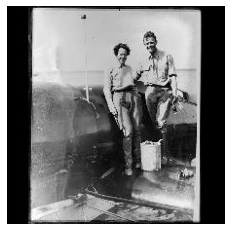

In [30]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

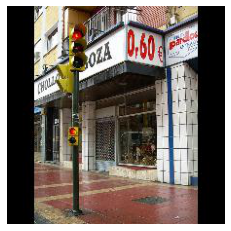

In [31]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [10]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [11]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

In [12]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [13]:
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(7, 7)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [22]:
model.fit(
    train_x,
    train_y,
    epochs=1,
    batch_size=batch_size
)

2500/2500 [==============================] - 56s 23ms/step - loss: 7.6085 - binary_accuracy: 0.5010


In [29]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset